## Task 1-2

In [165]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score

In [166]:


def loadData():
    data = pd.read_csv('campusDemand.csv', infer_datetime_format=True)
    
    pn = set(data['Point name'])
    print(pn)
    
    bdata = data.loc[data['Point name'] == 'Baker Hall Electric (Shark 29) - Demand Watts ']
    pdata = data.loc[data['Point name'] == 'Porter Hall Electric (Shark 30) - Watts']
    
    data = {}
    data["porter"] = pdata
    data["baker"] = bdata
    return data

data = loadData()


def createDF(df):
    return pd.DataFrame(index = pd.to_datetime(df['Time']),
                        data = df['Value'].values, columns=['D'])

data["porter"] = createDF(data["porter"])
data["baker"] = createDF(data["baker"])
# data = [createDF(x) for x in data]

{'Baker Hall Electric (Shark 29) - Watts', 'Doherty Apts Electric (Shark 11) - Demand Watts', 'Porter Hall Electric (Shark 30) - Watts', 'University Center Electric (Shark 34) - Watts', 'Scaife Hall Electric (Shark 21) - Watts', 'Baker Hall Electric (Shark 29) - Demand Watts ', 'Electric kW Calculations - Main Campus kW'}


## Task 3

In [167]:
def cleanData(df):
    # hard thresholding
    # any condition that introduces some kind of threshold is fine
    # in this case we prohibit values smaller than 2 stds, and introduce interpolation for missing values
    threshold = np.mean(df["D"])-1.5*np.std(df["D"])
    df["D"] = df["D"].apply(lambda x: x if x>threshold else np.nan)
    return df.interpolate()
    
data["porter"] = cleanData(data["porter"])
data["baker"] = cleanData(data["baker"])

data["porter"] = data["porter"].resample("1H").mean()
data["baker"] = data["baker"].resample("1H").mean()





## Task 4

In [168]:
def decompose(df):
    
    df1 = df.resample("1H").mean()
    df2 = df1.groupby(by=df1.index.date, as_index=False).transform(lambda x: (x/x.sum()))
#     threshold = np.mean(df2["D"])-1.5*np.std(df2["D"])
#     df2["D"] = df2["D"].apply(lambda x: x if x>threshold else np.nan)
    
    df3 = df1.resample("1D").sum()
    threshold = np.mean(df3["D"])-1.5*np.std(df3["D"])
    df3["D"] = df3["D"].apply(lambda x: x if x>threshold else np.nan)
#     print(df3)
    df3["dayofweek"] = df3.apply(lambda x: x.index.dayofweek)
#     print(df2)
    #[1:] because leading nans cannot be interpolated
    #also, from now on, we are not operating on dataframes anymore
    #but (ampltitude, loadcurve, values, dayofweek)-triples
    
    return (df2, df3)

data1 = {k: decompose(v) for k, v in data.items()}

data["porter"] = data["porter"].reset_index()
data["porter"]["hour"] = data["porter"]["Time"].apply(lambda x: x.hour)
data["porter"]["dofw"] = data["porter"]["Time"].apply(lambda x: x.dayofweek)

data["baker"] = data["baker"].reset_index()
data["baker"]["hour"] = data["baker"]["Time"].apply(lambda x: x.hour)
data["baker"]["dofw"] = data["baker"]["Time"].apply(lambda x: x.dayofweek)


## Task 5

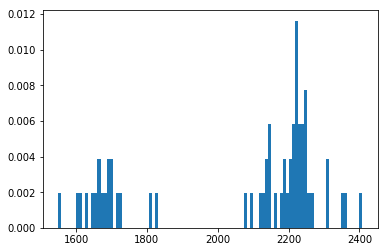

In [169]:
def dailyConsumptionDensity(a):
    plt.hist((a["D"].dropna())/1000, normed=True, bins=100)

dailyConsumptionDensity(data1["porter"][1])


# [dailyConsumptionDensity(x) for x in data1]

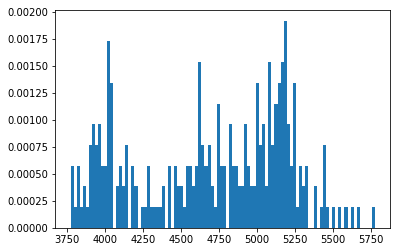

In [170]:
dailyConsumptionDensity(data1["baker"][1])

## Task 6

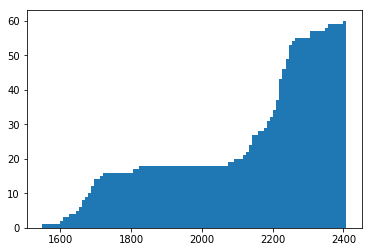

In [171]:
def dailyConsumptionCum(a):
    _ = plt.hist(a["D"].dropna()/1000, bins = 100, cumulative=True)

dailyConsumptionCum(data1["porter"][1])

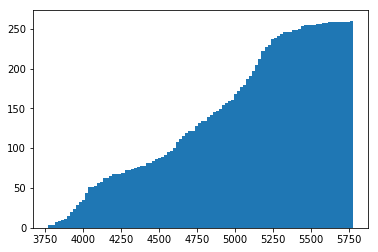

In [172]:
dailyConsumptionCum(data1["baker"][1])

## Task 7/8
The data is pretty sparse, i.e. we only have roughly 200 data points, so we cannot really identify a distribution.
However, when we look at the distribution of hourly consumption instead of the distribution of daily consumption, we can see nicer patterns (below).

The first distribution seems to be generated by a log-normal distribution, i.e. a slanted Gaussian distribution with a long tail. However, the second distribution seems more like a 2-mixture of Gaussians, since the distribution seems to be bi-modal.

In [175]:
data["porter"].head()

,Time,D,hour,dofw
0,2014-09-10 00:00:00,76943.120052,0,2
1,2014-09-10 01:00:00,70432.707682,1,2
2,2014-09-10 02:00:00,68766.224870,2,2
3,2014-09-10 03:00:00,71850.612760,3,2
4,2014-09-10 04:00:00,71016.477865,4,2


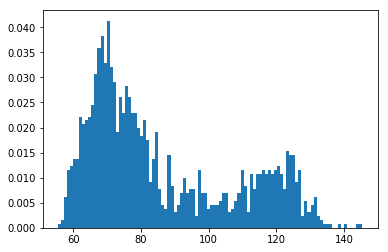

In [177]:
def hourlyConsumptionDensity(df):
    plt.hist(df["D"].dropna()/1000, bins = 100, normed=True)
    
    
def hourlyConsumptionCum(df):
    plt.hist(df["D"].dropna()/1000, bins = 100, cumulative=True)
    
# [hourlyConsumptionDensity(x[2]) for x in data]
hourlyConsumptionDensity(data["porter"])

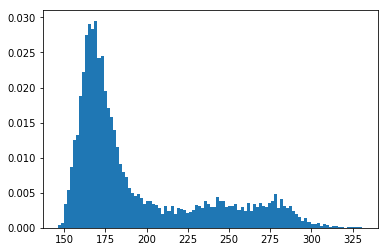

In [178]:
hourlyConsumptionDensity(data["baker"])

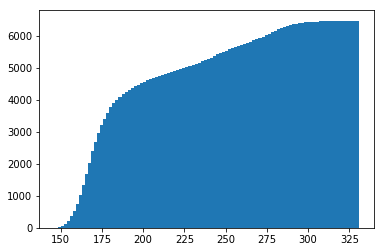

In [179]:
hourlyConsumptionCum(data["baker"])

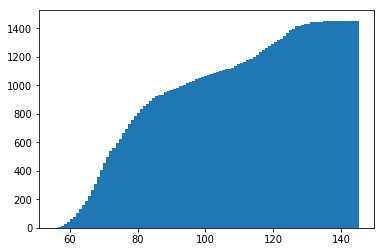

In [180]:
hourlyConsumptionCum(data["porter"])

## Task 9

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


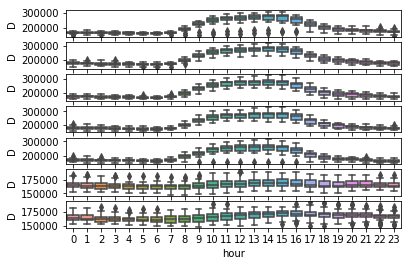

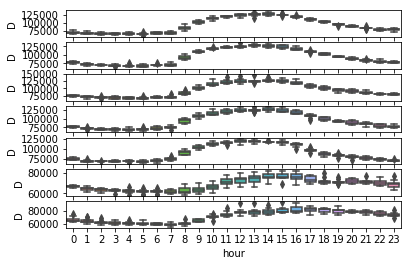

In [181]:
def plot_dailys(df):
    plt.figure()
    for i in range(7):
        plt.subplot(7, 1, i+1)
#         plt.subplots(1, 1, sharex=True, figsize=(24,10))
        sns.boxplot(x="hour", y="D", data=df[df["dofw"]==i])
        
plot_dailys(data["baker"])
plot_dailys(data["porter"])

## Task 10

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


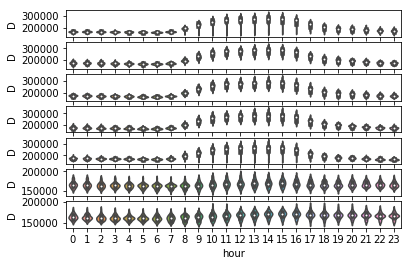

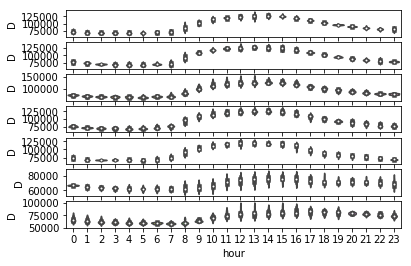

In [182]:
def plot_violin(df):
    plt.figure()
    for i in range(7):
        plt.subplot(7, 1, i+1)
#         plt.subplots(1, 1, sharex=True, figsize=(24,10))
        sns.violinplot(x="hour", y="D", data=df[df["dofw"]==i])
    
plot_violin(data["baker"])
plot_violin(data["porter"])

## Task 11

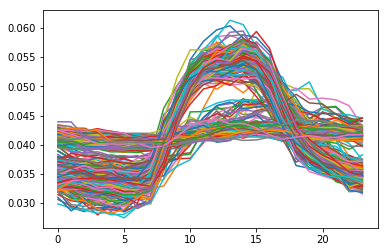

In [187]:
data1["porter"][0]["hour"] = data1["porter"][0].apply(lambda x: x.index.hour)
data1["baker"][0]["hour"] = data1["baker"][0].apply(lambda x: x.index.hour)

def plot_loadCurves_ugly(data):
    L = []
    for k, v in data.items():
        start = 0
        l = []
        for index, row in v[0].iterrows():
            if row["hour"] == 0:
                start = 1
            if start == 1:

                if row["hour"] == 0:
                    l = [row["D"]]
                    
                elif row["hour"] == 23:
                    l.append(row["D"]) 
                    l = pd.Series(l)
                    if not l.isnull().values.any():
                        L.append(list(l).copy())
                    l = []

                else:
                    l.append(row["D"])
    L = np.asarray(L)
    plt.plot(L.T)

plot_loadCurves_ugly(data1)

## Task 12

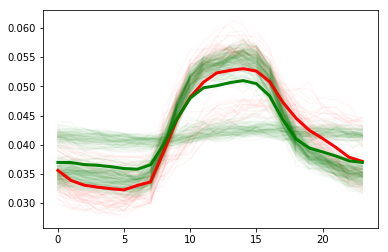

In [188]:
def plot_loadCurves_nice(data):
#     l = ["g", "r"]
    F = []
    
    for k, v in data.items():
        L = []
        start = 0
        l = []
        for index, row in v[0].iterrows():
            if row["hour"] == 0:
                start = 1
            if start == 1:

                if row["hour"] == 0:
                    l = [row["D"]]
                    
                elif row["hour"] == 23:
                    l.append(row["D"]) 
                    l = pd.Series(l)
                    if not l.isnull().values.any():
                        L.append(list(l).copy())
                    l = []
                else:
                    l.append(row["D"])
        L = np.asarray(L)
        F.append(L)
        
    plt.plot(F[0].T, color="r", alpha=0.03)
    plt.plot(F[1].T, color="g", alpha=0.03)
    plt.plot(np.mean(F[0],axis=0), color='r', alpha=1, linewidth='3')
    plt.plot(np.mean(F[1],axis=0), color='g', alpha=1, linewidth='3')
    
plot_loadCurves_nice(data1)

## Task 13
Some observations:
* Daily patterns of both meter are pretty similar in mean
* However, weekends are clearly visible for both meters, on top of that, weekend patterns differ:
* * flat green lines -> building probably unoccupied
* * phase shifted red lines -> people seem to arrive and leave later

## Task 14/15

In [189]:
def computeScatter(data, cluster_assign=None):
    F = []
    shapes = []
    for k, v in data.items():
        L = []
        start = 0
        l = []
        for index, row in v[0].iterrows():
            if row["hour"] == 0:
                start = 1
            if start == 1:

                if row["hour"] == 0:
                    l = [row["D"]]

                elif row["hour"] == 23:
                    l.append(row["D"]) 
                    l = pd.Series(l)
                    if not l.isnull().values.any():
                        L.append(list(l).copy())
                    l = []
                else:
                    l.append(row["D"])
        L = np.asarray(L)
        F.append(L)
        shapes.append(L.shape[0])
    
    F = np.concatenate([f for f in F])
    
    cluster_num = np.zeros(sum(shapes))
    cluster_num[shapes[0]:] = 1

    
    T = 0
    W = 0
    B = 0

    for i in range(sum(shapes)):
        for j in range(i, sum(shapes)):
            d = np.linalg.norm(F[i,:]-F[j,:])
            T+=d
            if cluster_num[j] == cluster_num[i]:
                #both load curves belong to same cluster
                W+=d
            else:
                B+=d
                
    return T,W,B

T, W, B = computeScatter(data1)
print('T',T,'B',B,'W',W,)

T 1111.7562682536923 B 371.58533765053596 W 740.1709306031447


## Task 16

In [190]:
def random_cluster(data, num):
    F = []
    shapes = []
    for k, v in data.items():
        L = []
        start = 0
        l = []
        for index, row in v[0].iterrows():
            if row["hour"] == 0:
                start = 1
            if start == 1:

                if row["hour"] == 0:
                    l = [row["D"]]

                elif row["hour"] == 23:
                    l.append(row["D"]) 
                    l = pd.Series(l)
                    if not l.isnull().values.any():
                        L.append(list(l).copy())
                    l = []
                else:
                    l.append(row["D"])
        L = np.asarray(L)
        F.append(L)
        shapes.append(L.shape[0])
    
    F = np.concatenate([f for f in F])
    
    cluster_num = np.random.choice(num, sum(shapes))
#     cluster_num[shapes[0]:] = 1

    
    T = 0
    W = 0
    B = 0

    for i in range(sum(shapes)):
        for j in range(i, sum(shapes)):
            d = np.linalg.norm(F[i,:]-F[j,:])
            T+=d
            if cluster_num[j] == cluster_num[i]:
                #both load curves belong to same cluster
                W+=d
            else:
                B+=d
                
    return T,W,B

T, W, B = random_cluster(data1, 3)
print('3 Clusters: T',T,'B',B,'W',W,)
T, W, B = random_cluster(data1, 5)
print('5 Clusters: T',T,'B',B,'W',W,)
T, W, B = random_cluster(data1, 10)
print('10 Clusters: T',T,'B',B,'W',W,)
# random_cluster(data)

3 Clusters: T 1111.7562682536923 B 741.9359095926794 W 369.82035866100415
5 Clusters: T 1111.7562682536923 B 891.3915514134752 W 220.36471684020285
10 Clusters: T 1111.7562682536923 B 999.8421949273919 W 111.91407332629365


## Task 17
We use two different 'features', i.e. the normalized load curves according to equation (1) of Kwarc and the unnormalized load curves. We try to tell three things from the clusters, i.e. the meter, day of the week and wether or not it is a weekend day.
As a metric for how well we are doing, we use mutual information. Below are the scores for the resulting 6 settings.

In [192]:

F = []
dofw = []
shapes = []
clus = []
for k, v in data1.items():
    L = []
    start = 0
    l = []
    for index, row in v[0].iterrows():
        if row["hour"] == 0:
            start = 1
        if start == 1:

            if row["hour"] == 0:
                l = [row["D"]]

            elif row["hour"] == 23:
                l.append(row["D"]) 
                l = pd.Series(l)
                if not l.isnull().values.any():
                    clus.append(k)
                    dofw.append(index.dayofweek)
                    L.append(list(l).copy())
                l = []
            else:
                l.append(row["D"])
    L = np.asarray(L)
    F.append(L)
#     shapes.append(L.shape[0])

F = np.concatenate([f for f in F])
dofw = np.asarray(dofw)
wde = dofw>4
len(F), len(dofw), len(clus)


(318, 318, 318)

In [193]:
F1 = []
dofw1 = []
shapes = []
clus1 = []
for k, v in data.items():
    L = []
    start = 0
    l = []
    for index, row in v.iterrows():
        if row["hour"] == 0:
            start = 1
        if start == 1:

            if row["hour"] == 0:
                l = [row["D"]]

            elif row["hour"] == 23:
                l.append(row["D"]) 
                l = pd.Series(l)
                if not l.isnull().values.any():
                    clus1.append(k)
                    dofw1.append(row["Time"].dayofweek)
                    L.append(list(l).copy())
                l = []
            else:
                l.append(row["D"])
    L = np.asarray(L)
    F1.append(L)
#     shapes.append(L.shape[0])

F1 = np.concatenate([f for f in F1])
dofw1 = np.asarray(dofw1)
wde1 = dofw1>4
len(F1), len(dofw1), len(clus1)


(318, 318, 318)

In [194]:
def kMean_find(F, dofw, clus, wde, c):
    print("For", c)
    k = KMeans(n_clusters=2)
    assign = k.fit_predict(F)
    print('Meter: MI', mutual_info_score(clus, assign))
    print('weekend: MI', mutual_info_score(wde, assign))
    k = KMeans(n_clusters=7)
    assign = k.fit_predict(F)
    print('DayOfWeek: MI', mutual_info_score(dofw, assign))

    
kMean_find(F, dofw, clus, wde, "Normalized Load Curves")
kMean_find(F1, dofw1, clus1, wde1, "Unnormalized Load Curves")



For Normalized Load Curves
Meter: MI 8.75015217166597e-05
weekend: MI 0.5676165366187995
DayOfWeek: MI 0.6611540242682785
For Unnormalized Load Curves
Meter: MI 0.46542888382868103
weekend: MI 0.00025970488622625854
DayOfWeek: MI 0.617425450318616
